Libraries

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt

Dataset

In [3]:
txt = open('tiny_shakespeare.txt', 'r').read()
# txt[0:10], list(txt)[:10], list(set(txt))[:10]
vocab = sorted(list(set(txt)))
itos = {i:ch for i, ch in enumerate(vocab)}
stoi = {ch:i for i, ch in enumerate(vocab)}

Hyperparameters

In [4]:
hparams = {'vocab_size': len(vocab)}

Character Level Tokenizer

In [5]:
def encode(s):
    return [stoi[i] for i in s]

def decode(l):
    return ''.join(itos[i] for i in l)
decode(encode('test'))

'test'

In [6]:
dataset = torch.tensor(encode(txt), dtype=torch.int8)
dataset.dtype, dataset.shape, dataset[:5]

(torch.int8,
 torch.Size([1115394]),
 tensor([18, 47, 56, 57, 58], dtype=torch.int8))

Batches

In [7]:
hparams.update({'batch_size': 8, 'context_window': 16})

In [8]:
def create_batch(dataset, split, batch_size, context_window):
    # 80, 10, 10 split
    train = dataset[:int(.8*len(dataset))]
    val = dataset[int(.8*len(dataset)):int(.9*len(dataset))]
    test = dataset[int(.9*len(dataset)):]

    batch = train if split=='train' else (val if split=='val' else test)

    idx = torch.randint(0, batch.size(0)-context_window-1, (batch_size,))
    x = torch.stack([batch[i:i+context_window] for i in idx]).long()
    y = torch.stack([batch[i+1:i+context_window+1] for i in idx]).long()
    yield (x, y)

In [9]:
x, y = next(create_batch(dataset, 'val', hparams['batch_size'], hparams['context_window']))
# print(x, y)
[decode(i) for i in x.tolist()], [decode(i) for i in y.tolist()]

(['nk you have made',
  'on or reprieve\nF',
  ', leave that lab',
  'and by.\nI hope i',
  'Hark you, sir: I',
  's he spake again',
  'ut he was.\n\nLUCI',
  'd personally acc'],
 ['k you have made ',
  'n or reprieve\nFo',
  ' leave that labo',
  'nd by.\nI hope it',
  "ark you, sir: I'",
  ' he spake agains',
  't he was.\n\nLUCIO',
  ' personally accu'])

In [10]:
hparams.update({'embed_dim': 128})

RMS Pre-Normalization
https://github.com/meta-llama/llama/blob/main/llama/model.py#L34-L77

In [32]:
class RMSNorm(nn.Module):
    def __init__(self, dim, eps=1e-6):
        super(RMSNorm, self).__init__()
        self.eps = eps
        self.register_parameter('scale', nn.Parameter(torch.ones(dim)))

    def _norm(self, x):
        return x*torch.rsqrt(x.pow(2).mean(-1, keepdim=True) + self.eps)

    def forward(self, x):
        return (self._norm(x.float()).type_as(x)) * self.scale


Rotary Positional Embeddings - RoPE

$q_m^T k_n = (R^d_{\Theta, m}W_q x_m)^T (R^d_{\Theta, n} W_k x_n) = x^T W_q R^d_{\Theta, n-m} W_k x_n.$

In [12]:
hparams.update({'num_heads': 8})

In [25]:
def rotary_matrix(context_window, embedding_dim):
    R = torch.zeros((context_window, embedding_dim, embedding_dim), requires_grad=False)
    for position in range(context_window):
        for i in range(embedding_dim//2):
            theta = 10000. ** (-2.*(i - 1) / embedding_dim)
            m_theta = position * theta
            R[position, 2*i,2*i] = np.cos(m_theta)
            R[position, 2*i,2*i+1] = - np.sin(m_theta)
            R[position, 2*i+1,2*i] = np.sin(m_theta)
            R[position, 2*i+1,2*i+1] = np.cos(m_theta)
    return R

In [26]:
class RoPEMaskedAttentionHead(nn.Module):
    def __init__(self, hparams):
        super().__init__()
        self.hparams = hparams
        self.w_q = nn.Linear(hparams['embed_dim'], hparams['embed_dim'], bias=False)
        self.w_k = nn.Linear(hparams['embed_dim'], hparams['embed_dim'], bias=False)
        self.w_v = nn.Linear(hparams['embed_dim'], hparams['embed_dim'], bias=False)

        self.R = rotary_matrix(hparams['context_window'], hparams['embed_dim'])

    def forward(self, x, return_attn_weights=False):
        b,m,d = x.shape # batch_size, sequence_length/context_window, embedding dimension

        q = self.w_q(x)
        k = self.w_k(x)
        v = self.w_v(x)

        q_rotated = (torch.bmm(q.transpose(0,1), self.R[:m])).transpose(0,1)
        k_rotated = (torch.bmm(k.transpose(0,1), self.R[:m])).transpose(0,1)

        activations = F.scaled_dot_product_attention(
            q_rotated,k_rotated,v,dropout_p =.1, is_causal=True
        )

        if return_attn_weights:
            attn_mask = torch.tril(torch.ones((m,m)), diagonal=0)
            attn_weights = torch.bmm(q_rotated, k_rotated.transpose(1,2)) / np.sqrt(d) + attn_mask
            attn_weights = F.softmax(attn_weights, dim=-1)
            return activations, attn_weights
        return activations

In [27]:
class RoPEMaskedMultiheadAttention(nn.Module):
    def __init__(self, hparams):
        super().__init__()
        self.hparams = hparams
        self.heads = nn.ModuleList([
            RoPEMaskedAttentionHead(hparams) for _ in range(hparams['num_heads'])
        ])
        self.linear = nn.Linear(hparams['num_heads'] * hparams['embed_dim'], hparams['embed_dim'])
        self.dropout = nn.Dropout(.1)

    def forward(self, x):
        heads = [h(x) for h in self.heads]
        x = torch.cat(heads, dim=-1)
        x = self.linear(x)
        x = self.dropout(x)
        return x

SWIGLU activation

$\text{Swish}_\beta(x) = x \sigma(\beta x)$

$\text{SwiGLU}(x) = \text{Swish}_\beta (xW + b) \otimes (xV + c)$

In [15]:
class SwiGLU(nn.Module):
    def __init__(self, size):
        super().__init__()
        self.hparams = hparams
        self.linear_gate = nn.Linear(size, size)
        self.linear = nn.Linear(size, size)
        self.beta = nn.Parameter(torch.ones(1))
        self.register_parameter("beta", self.beta)

    def forward(self, x):
        swish_gate = self.linear_gate(x) * torch.sigmoid(self.beta * self.linear_gate(x))
        out = swish_gate * self.linear(x)
        return out

LLaMa Model

In [95]:
class LlamaBlock(nn.Module):
    def __init__(self, hparams):
        super().__init__()
        self.hparams = hparams

        self.rms = RMSNorm((hparams['context_window'], hparams['embed_dim']))

        self.attention = RoPEMaskedMultiheadAttention(hparams)
        self.feedforward = nn.Sequential(
            nn.Linear(hparams['embed_dim'], hparams['embed_dim']),
            SwiGLU(hparams['embed_dim']),
        )

    def forward(self, x):
        x = self.rms(x) # rms pre-normalization
        x = x + self.attention(x)

        x = self.rms(x) # rms pre-normalization
        x = x + self.feedforward(x)
        return x

In [17]:
from collections import OrderedDict

hparams.update({'num_layers': 4})

In [96]:
class Llama(nn.Module):
    def __init__(self, hparams):
        super().__init__()
        self.hparams = hparams
        self.embeddings = nn.Embedding(hparams['vocab_size'], hparams['embed_dim'])
        self.llama_blocks = nn.Sequential(
            OrderedDict([(f"llama_{i}", LlamaBlock(hparams)) for i in range(hparams['num_layers'])])
        )

        self.ffn = nn.Sequential(
            nn.Linear(hparams['embed_dim'], hparams['embed_dim']),
            SwiGLU(hparams['embed_dim']),
            nn.Linear(hparams['embed_dim'], hparams['vocab_size']),
        )

        print("model params:", sum([m.numel() for m in self.parameters()]))

    def forward(self, idx, targets=None):
        x = self.embeddings(idx)
        x = self.llama_blocks(x)
        logits = self.ffn(x)

        if targets is None:
            return logits

        else:
            loss = F.cross_entropy(logits.view(-1, self.hparams['vocab_size']), targets.view(-1))
            return logits, loss

Training

In [20]:
hparams.update({'epochs': 1000, 'log_interval': 10})

In [21]:
hparams

{'vocab_size': 65,
 'batch_size': 8,
 'context_window': 16,
 'embed_dim': 128,
 'num_heads': 8,
 'num_layers': 4,
 'epochs': 1000,
 'log_interval': 10}

In [22]:
@torch.no_grad()
def evaluate_loss(model):
    out = {}
    model.eval()
    for split in ["train", "val"]:
        losses = []
        for _ in range(10):
            xb, yb = next(create_batch(dataset, split, hparams['batch_size'], hparams['context_window']))
            _, loss = model(xb, yb)
            losses.append(loss.item())
        out[split] = np.mean(losses)
    model.train()
    return out

In [23]:
def train(model, optimizer, scheduler=None, print_logs=False):
    losses = []
    start_time = time.time()
    for epoch in range(hparams['epochs']):
        optimizer.zero_grad()

        x, y = next(create_batch(dataset, 'train', hparams['batch_size'], hparams['context_window']))
        logits, loss = model(x, targets=y)
        loss.backward()
        optimizer.step()

        if scheduler:
            scheduler.step()

        if epoch % hparams['log_interval'] == 0:
            batch_time = time.time() - start_time
            x = evaluate_loss(model)
            losses += [x]
            if print_logs:
                print(f"Epoch {epoch} | val loss {x['val']:.3f} | Time {batch_time:.3f} | ETA in seconds {batch_time * (hparams['epochs'] - epoch)/hparams['log_interval'] :.3f}")
            start_time = time.time()

            if scheduler:
                print("lr: ", scheduler.get_lr())

    print("validation loss: ", losses[-1]['val'])
    return pd.DataFrame(losses).plot()


In [98]:
llama = Llama(hparams)
optimizer = torch.optim.Adam(llama.parameters())

model params: 2370246


validation loss:  3.2799296617507934


<Axes: >

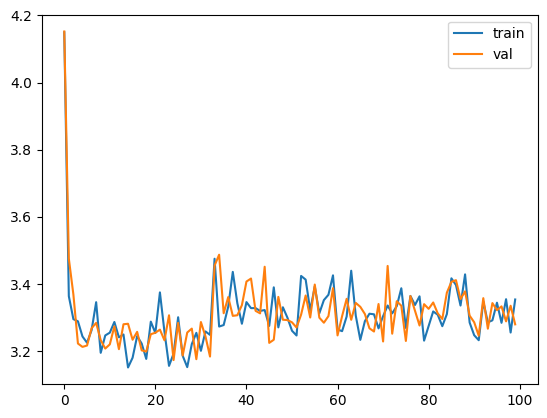

In [99]:
train(llama, optimizer, print_logs=False)

Generate text using the trained model

In [100]:
def generate(model, max_new_tokens):
    idx = torch.zeros(5, 1).long()
    for _ in range(max_new_tokens):
        logits = model(idx[:, -hparams['context_window']:])
        last_time_step_logits = logits[
            :, -1, :
        ]  # all the batches (1), last time step, all the logits
        p = F.softmax(last_time_step_logits, dim=-1)  # softmax to get probabilities
        idx_next = torch.multinomial(
            p, num_samples=1
        )  # sample from the distribution to get the next token
        idx = torch.cat([idx, idx_next], dim=-1)  # append to the sequence
    return [decode(x) for x in idx.tolist()]


In [102]:
out = generate(llama, 500)

In [105]:
print(out[0])


tkynbrrrtrhhaBrcTaf EWntsh ent vo moP wu illwnecls
u I gI piyaaioo  snta
atmdn w o WP  yr:a snetun 
tdhlmundtrnwtlsnf h?yoOtoa Nolr dtmtt :tyi  ondiliwUpdta  Dishdrrrm cdudyegi ee dtsn
eredeenidaeeroterlite  nahn otg
joe 
ic mhhsat ssdarsduafE: orosal so hwa'oiooepeoro',asW eo ,eO
s sn:',ue ,sHiier hegl e wotoeIsrgr,n   , gni, w ela:  euoho ofh  rh ei m utnen.  nwmbhOIhLsneb !nwsmdo 
e shnnypr e?n,f  
  ho o ae:dT mlo y,a :pi,G ihrA
EMh s no lodeetRoWegenoer 
w  oetab,pem,noaoo h  bna'c.eeaE
une
